In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('filtered_dataset.csv')
df = df.drop('sprintName', axis=1)

df = df.drop(columns=["blockedBy", "blocks", "priorityId", "assignee_summary"], axis=1)

category_columns = df.loc[:, df.dtypes == 'object'].columns.drop(['sprintStartDate', 'sprintEndDate'])
numeric_columns = df.loc[:, df.dtypes != 'object'].columns.drop(['sprintId'])

for feature in category_columns:
    le = LabelEncoder()
    df[f'{feature}_encoded'] = le.fit_transform(df[feature])

df = df.drop(columns=category_columns)

for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())


df = df.drop(columns=['sprintStartDate', 'sprintEndDate'], axis=1)

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] 
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] 
    
correlation(df, 0.9)

numeric_columns = df.loc[:, df.dtypes != 'object'].columns.drop(['sprintId'])

df = df.dropna(subset=['sprintId'])

In [3]:
# Создаем новый датафрейм с агрегированными метриками по каждому спринту
aggregated_features = df.groupby('sprintId').agg({
    'priority': ['mean', 'sum'],
    'storyPoint': ['mean', 'sum'],
    'issueLinks': ['mean', 'sum'],
    'votes': ['mean', 'sum'],
    'watchcount': ['mean', 'sum'],
    'subtasks': ['mean', 'sum'],
    'initialStoryPoint': ['mean', 'sum'],
    'totalNumberOfIssues': ['mean', 'sum'],
    'completedIssuesCount': ['mean', 'sum'],
    'puntedIssues': ['mean', 'sum'],
    'issuesNotCompletedInCurrentSprint': ['mean', 'sum'],
    'completedIssuesEstimateSum': ['mean', 'sum'],
    'NoOfDevelopers': ['mean', 'sum'],
    'SprintLength': ['mean', 'sum'],
    'issueType_encoded': 'sum',  
    'status_issues_encoded': 'sum', 
    'status_summary_encoded': ['mean', 'sum'],  
    'sprintState_encoded': 'sum'
}).reset_index()

In [4]:
# Преобразуем имена колонок в формат 'feature_aggregation'
aggregated_features.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_features.columns]


In [5]:
aggregated_features.head()

,sprintId_,priority_mean,priority_sum,storyPoint_mean,storyPoint_sum,issueLinks_mean,issueLinks_sum,votes_mean,votes_sum,watchcount_mean,...,completedIssuesEstimateSum_sum,NoOfDevelopers_mean,NoOfDevelopers_sum,SprintLength_mean,SprintLength_sum,issueType_encoded_sum,status_issues_encoded_sum,status_summary_encoded_mean,status_summary_encoded_sum,sprintState_encoded_sum
0,1.0,3.375000,54.0,2.062500,33.0,0.125000,2.0,0.0,0.0,1.687500,...,288.0,8.0,128.0,21.0,336.0,30,0,0.937500,15,0
1,3.0,3.625000,58.0,2.562500,41.0,0.187500,3.0,0.0,0.0,1.250000,...,160.0,6.0,96.0,8.0,128.0,32,0,1.187500,19,0
2,4.0,3.764706,64.0,5.058824,86.0,0.235294,4.0,0.0,0.0,1.352941,...,1224.0,9.0,153.0,6.0,102.0,34,0,0.352941,6,0
3,5.0,4.000000,148.0,2.054054,76.0,0.081081,3.0,0.0,0.0,1.540541,...,2146.0,10.0,370.0,8.0,296.0,74,0,0.810811,30,0
4,6.0,4.000000,172.0,3.046512,131.0,0.093023,4.0,0.0,0.0,1.581395,...,2838.0,10.0,430.0,6.0,258.0,82,0,0.488372,21,0


In [24]:
data_for_scaling = aggregated_features.drop(columns=['sprintId_'], axis=1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_scaling)

scaled_data = pd.DataFrame(scaled_data, columns=data_for_scaling.columns)



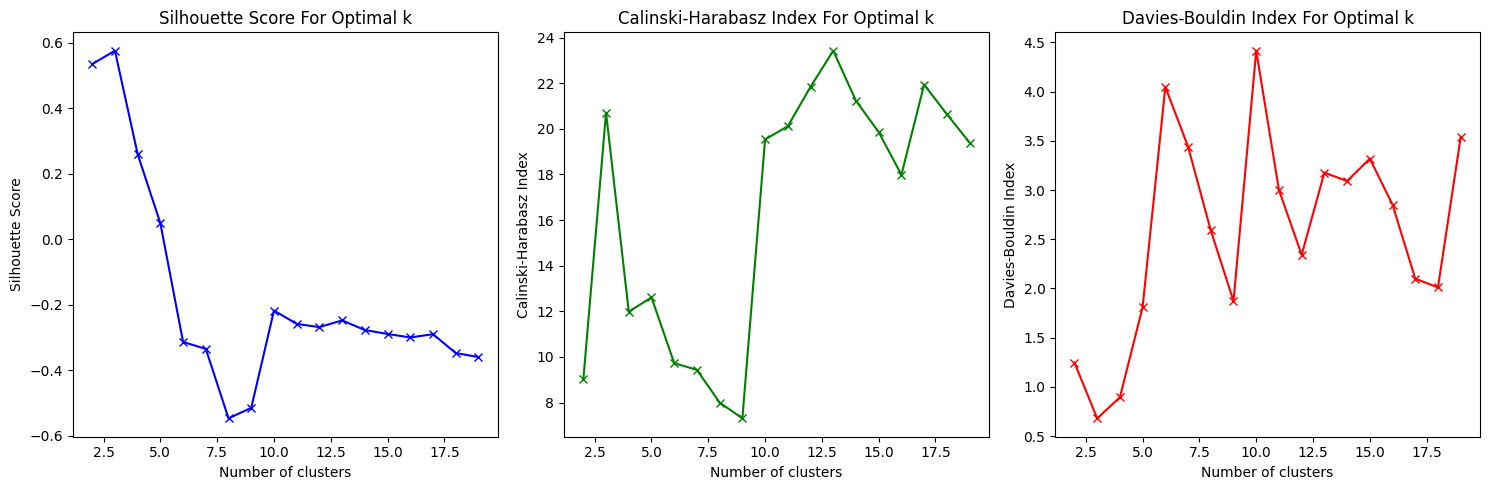

Optimal number of clusters based on silhouette score: 3


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=min(aggregated_features.drop(columns=['sprintId_']).shape[1], 10))),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

aggregated_features['cluster'] = final_pipeline.fit_predict(aggregated_features.drop(columns=['sprintId_']))


